In [424]:
import numpy as np
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

# Feature selection modules
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from scipy import stats

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from catboost import CatBoostClassifier, Pool, cv

from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
import category_encoders as ce # Encoding modules
# Hyperparameter tuning modules
from sklearn.model_selection import GridSearchCV

# Data sampling modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Model saving module
import pickle


### 0. Statement of business problems:
#### It is necessary to implement a set of measures to detect fraud in the banking sector.
#### It is necessary to detect situations when a fraudster makes payments on a card without the knowledge of the owner. One of the most effective tools for solving the problem of identifying fraudulent banking transactions is machine learning. Note that the sample is often unbalanced and cannot be so; fraudulent transactions of the total number of transactions fluctuate around 2%.

### Metric selection
In our case, having an unbalanced sample, Accuracy is not applicable.
If it is important to minimize false negatives, then the Recall metric will be more appropriate. Recall measures the proportion of all true positive cases that the model classified correctly.
Thus, the higher the Recall, the fewer false negatives the model has. This is especially important in cases where false negatives can have serious consequences
In such tasks that solve the problem of detecting high risk, the Recall metric is the most suitable; you can also focus on the complex metric F 1 score.

### 1. Getting to know the data and handling gaps

In [35]:
df = pd.read_csv('dataset.csv')
df.head(2)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,event_timestamp,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,fraud
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,12/29/2020 9:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,False
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,6/22/2021 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,False


### Description of symptoms

1.	account_age_days: Account age in days (numeric value).
2.	transaction_amt: Transaction amount (numeric value).
3.	transaction_adj_amt: Adjusted transaction amount (numeric value).
4.	historic_velocity: Historical transaction velocity (numeric value).
5.	ip_address: IP address (string value).
6.	user_agent: User agent information (string value).
7.	email_domain: Email domain (string value).
8.	phone_number: Phone number (string value).
9.	billing_city: Billing city (string value).
10.	billing_postal: Billing postal code (numeric value).
11.	billing_state: Billing state (string value).
12.	card_bin: Card BIN (numeric value).
13.	currency: Transaction currency (string value).
14.	signature_image: Signature image (string value).
15.	transaction_type: Transaction type (string value).
16.	transaction_env: Transaction environment (string value).
17.	event_timestamp: Event timestamp (string value).
18.	applicant_name: Applicant name (string value).
19.	billing_address: Billing address (string value).
20.	merchant_id: Merchant ID (string value).
21.	locale: Locale (string value).
22.	transaction_initiate: Transaction initiation (string value).
23.	days_since_last_logon: Days since last logon (numeric value).
24.	inital_amount: Initial amount (numeric value).
25.	fraud: Target variable indicating whether the transaction is fraudulent (binary value).

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  signature_image        149895 non-null  object 
 14  transaction_type       149884 non-nu

In [37]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
print(df['event_timestamp'].max())
print(df['event_timestamp'].min())

2021-10-25 14:27:00
2020-10-25 08:44:00


So we have a dataset with transaction data for a year, there is a target sign of fraud, we will try to determine it based on dependencies in the data. We will use the F1 score metric for assessing the quality of the model.

### 2. Preprocessing

In [38]:
df.duplicated().sum() #duplicate

0

In [39]:
df.isnull().sum() #data gaps

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
signature_image          105
transaction_type         116
transaction_env          123
event_timestamp          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
fraud                      0
dtype: int64

In [40]:
df.fraud.value_counts() #target variable distribution

False    141836
True       8164
Name: fraud, dtype: int64

Fraudulent transactions with data gaps of less than 2 percent of the data. We decide to remove them

In [41]:
#how many missing values ​​in the data where the transaction turned out to be fraudulent
df.loc[df['fraud'] == True].isnull().sum() 

account_age_days          6
transaction_amt           8
transaction_adj_amt      10
historic_velocity         3
ip_address                5
user_agent                7
email_domain              2
phone_number              5
billing_city              5
billing_postal            8
billing_state             7
card_bin                  8
currency                  7
signature_image           7
transaction_type          5
transaction_env           2
event_timestamp           6
applicant_name            4
billing_address          10
merchant_id               5
locale                    6
tranaction_initiate       4
days_since_last_logon     9
inital_amount            10
fraud                     0
dtype: int64

In [42]:
#how many transactions with empty values ​​for at least one attribute
df.loc[df['fraud'] == True].isnull().any(axis=1).sum()

149

Fraudulent transactions with data gaps of less than 2 percent of the data. We decide to remove them

In [43]:
df.dropna(axis=0, inplace=True)
df.fraud.value_counts()

False    139108
True       8015
Name: fraud, dtype: int64

__Before the omissions were removed, the percentage of fraudulent transactions was 5.75%; after the omissions were removed, the percentage changed slightly to 5.76%__

### 3. Exploratory data analysis and feature engineering

In [44]:
df.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
count,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000
mean,4645.914901,2521.396457,54.207466,4702.460173,50181.423720,41834.534560,49.861225,7996.496401
std,1153.744713,604.644319,10.068261,1188.161407,28388.654516,10081.175293,29.209468,4048.005539
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25298.000000,35386.000000,24.000000,4484.000000
50%,4668.000000,2543.000000,55.000000,4730.000000,50072.000000,42086.000000,50.000000,7999.000000
75%,5476.000000,2951.000000,61.000000,5549.000000,74346.000000,47373.000000,75.000000,11494.500000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000


The data is quite logical, there are no negative values, completely acceptable figures for the life of the account, amounts in the account, etc.

Let's take a closer look at the account_age_days attribute

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


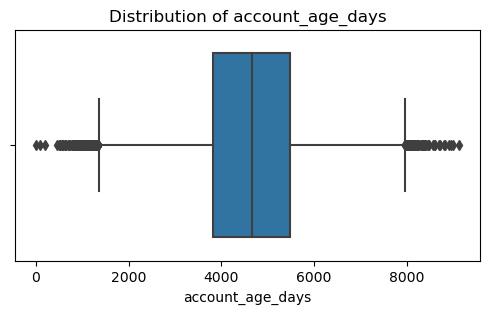

In [45]:
plt.figure(figsize=(6,3), facecolor='white')
sns.boxplot(df['account_age_days'])
plt.title('Distribution of account_age_days')
plt.show()

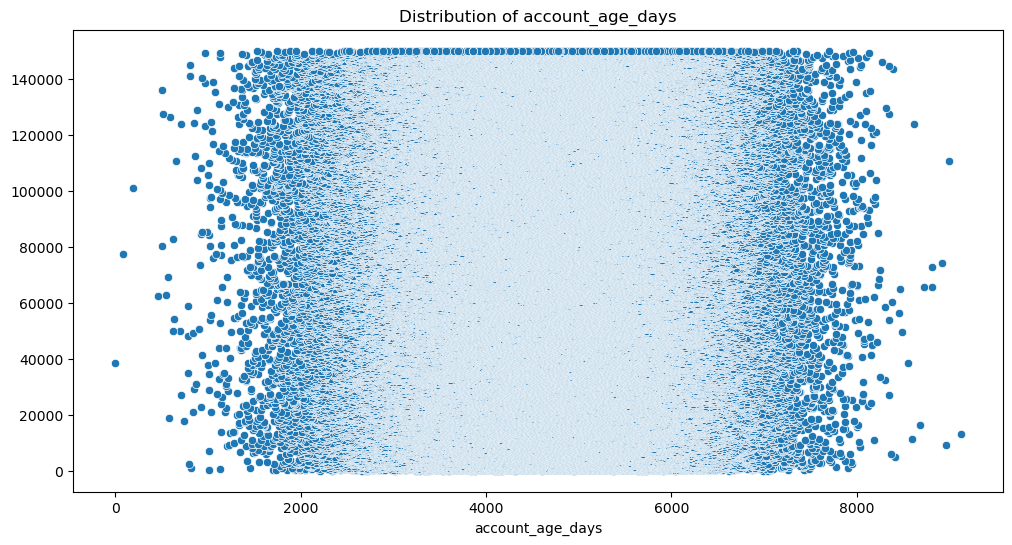

In [46]:
plt.figure(figsize=(12,6), facecolor='white')
sns.scatterplot(x=df['account_age_days'], y=df.index)
plt.title('Distribution of account_age_days')
plt.show()

It can be seen that there is a certain number of days with the account_age_days attribute closer to 0 and above 8 thousand days, but within the framework of the considered attribute this is not anomalous. The bulk is concentrated between 2 and 8 thousand days.

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


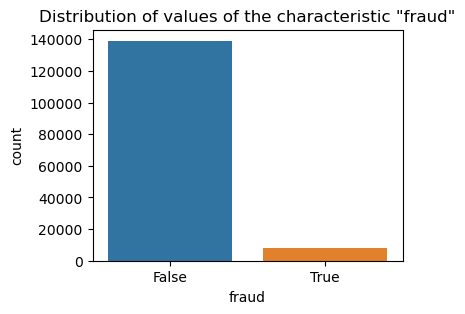

In [47]:
#Distribution of values ​​of the characteristic 'fraud'
plt.figure(figsize=(4,3), facecolor='white')
sns.countplot(df['fraud'])
plt.title('Distribution of values ​​of the characteristic "fraud"')
plt.show()

Let's look at the distribution of numerical characteristics

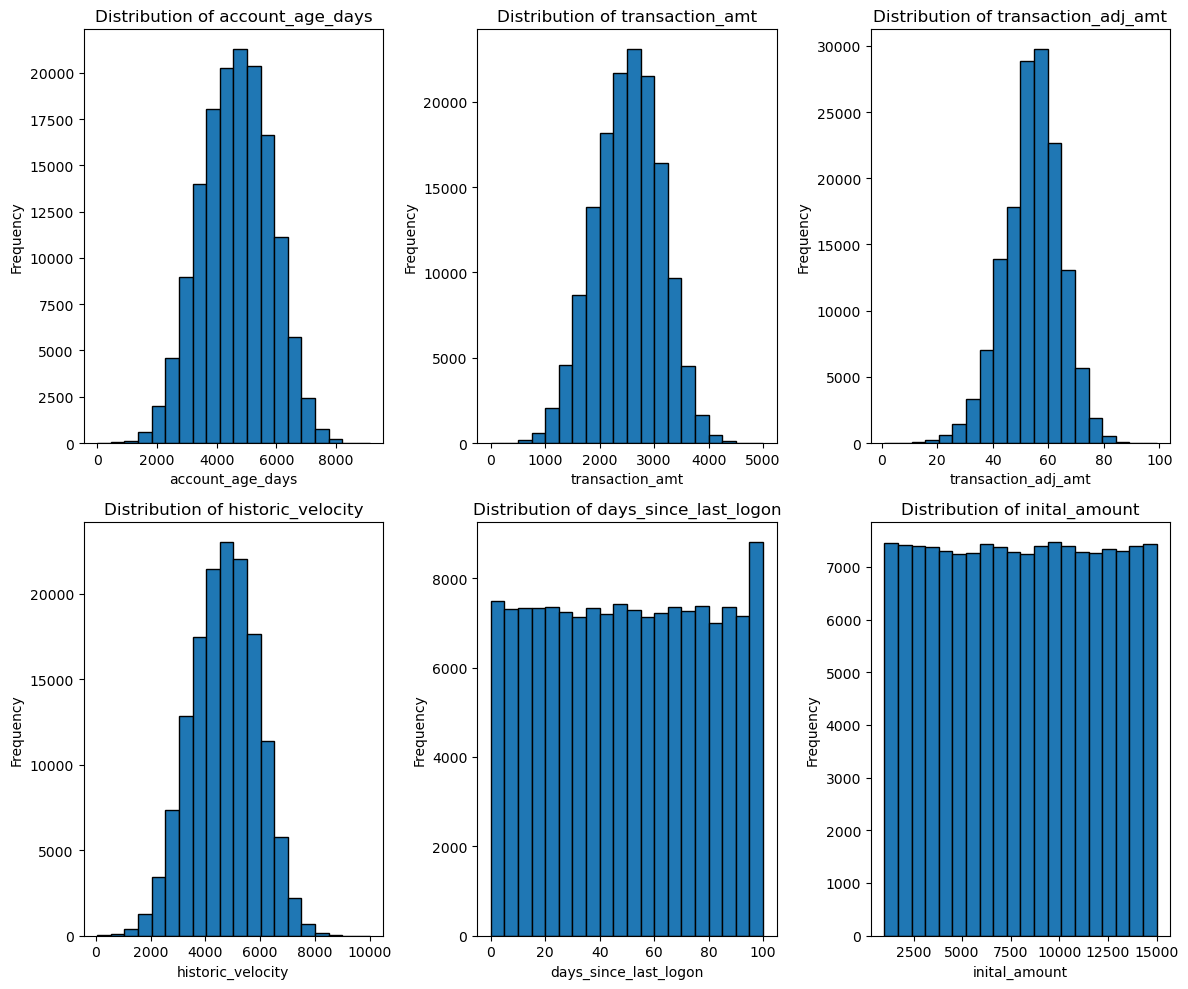

In [48]:
# Create a coordinate plane with 2x2 graphs
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10), facecolor='white')
# List of features for plotting
features = ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'days_since_last_logon', 'inital_amount']

# For each feature we build a histogram on the corresponding graph
for ax, feature in zip(axes.flatten(), features):
    ax.hist(df[feature], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Let's take a closer look at the days_since_last_logon sign

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


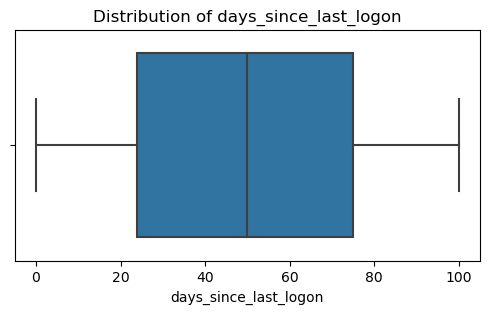

In [49]:
plt.figure(figsize=(6,3), facecolor='white')
sns.boxplot(df['days_since_last_logon'])
plt.title('Distribution of days_since_last_logon')
plt.show()

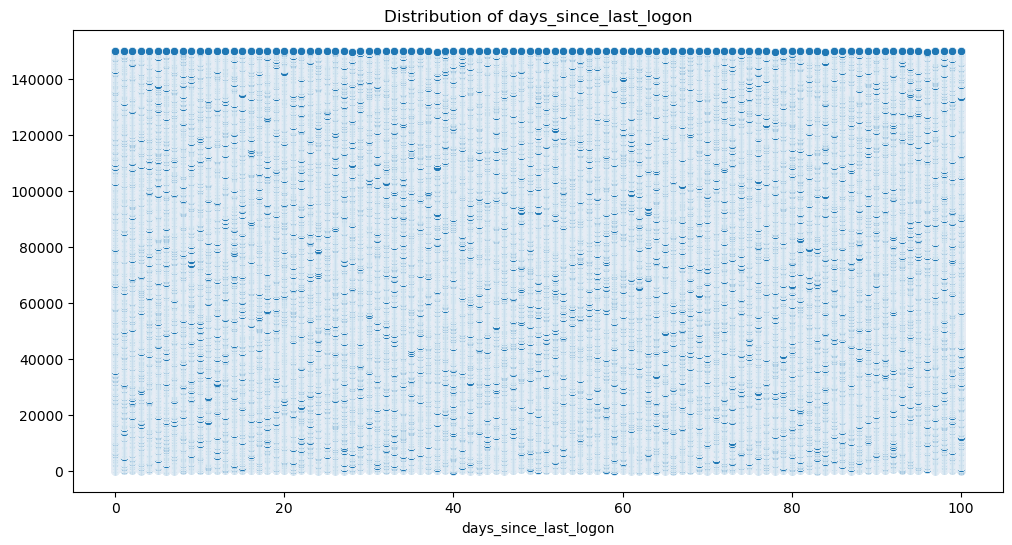

In [50]:
plt.figure(figsize=(12,6), facecolor='white')
sns.scatterplot(x=df['days_since_last_logon'], y=df.index)
plt.title('Distribution of days_since_last_logon')
plt.show()

Visualization of numerical features represents the identification of normal distribution in them

In [51]:
data = df.copy()

It would be interesting to see whether there is a dependence in fraudulent transactions on a new account or not, whether many days have passed since the last logging or not?

In [52]:
data['group_account_age_days'] = data['account_age_days'].apply(lambda x: 
    1 if x < 1000 
    else (2 if x < 2000 
          else (3 if x < 3000 
                else (4 if x < 4000 
                      else (5 if x < 5000 
                            else (6 if x < 6000 
                                  else (7 if x < 7000 
                                        else (8 if x < 8000 
                                              else (9 if x < 9000 
                                                    else 10)))))))))

data.groupby('group_account_age_days')['fraud'].value_counts(normalize=True) * 100

group_account_age_days  fraud
1                       False     97.826087
                        True       2.173913
2                       False     99.586093
                        True       0.413907
3                       False     99.392807
                        True       0.607193
4                       False     98.660197
                        True       1.339803
5                       False     94.871568
                        True       5.128432
6                       False     90.490383
                        True       9.509617
7                       False     92.029031
                        True       7.970969
8                       False     93.822739
                        True       6.177261
9                       False     95.555556
                        True       4.444444
10                      False    100.000000
Name: fraud, dtype: float64

In [53]:
data.groupby('group_account_age_days')['fraud'].value_counts()

group_account_age_days  fraud
1                       False       45
                        True         1
2                       False     1203
                        True         5
3                       False    10640
                        True        65
4                       False    31517
                        True       428
5                       False    42807
                        True      2314
6                       False    36131
                        True      3797
7                       False    14582
                        True      1263
8                       False     2096
                        True       138
9                       False       86
                        True         4
10                      False        1
Name: fraud, dtype: int64

In [54]:
data['group_days_since_last_logon'] = df['days_since_last_logon'].apply(lambda x: 
    1 if x < 10 
    else (2 if x < 20 
          else (3 if x < 30 
                else (4 if x < 40 
                      else (5 if x < 50 
                            else (6 if x < 60 
                                  else (7 if x < 70 
                                        else (8 if x < 80 
                                              else (9 if x < 90
                                                    else 10)))))))))


In [55]:
data.groupby('group_account_age_days')['fraud'].value_counts(normalize=True) * 100

group_account_age_days  fraud
1                       False     97.826087
                        True       2.173913
2                       False     99.586093
                        True       0.413907
3                       False     99.392807
                        True       0.607193
4                       False     98.660197
                        True       1.339803
5                       False     94.871568
                        True       5.128432
6                       False     90.490383
                        True       9.509617
7                       False     92.029031
                        True       7.970969
8                       False     93.822739
                        True       6.177261
9                       False     95.555556
                        True       4.444444
10                      False    100.000000
Name: fraud, dtype: float64

Signs based on the number of days since the last logging and the age of the account do not yet provide any interesting information, perhaps new signs will be useful to us

Look at what currency fraud occurs most often.

In [56]:
data[data['fraud']==True]['currency'].value_counts()

cad    5684
usd    1887
eur     444
Name: currency, dtype: int64

Let's see if we can identify any pattern depending on the date of the transaction


In [57]:
data['year'] = data['event_timestamp'].dt.year
data['month'] = data['event_timestamp'].dt.month
data['hour'] = data['event_timestamp'].dt.hour
data['day_of_week'] = data['event_timestamp'].dt.day_of_week

Text(0.5, 1.0, 'Distribution of fraud transactions by months')

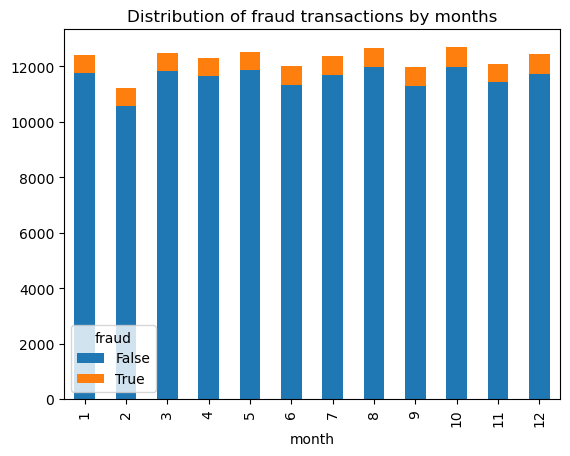

In [58]:
types = data.groupby("month")['fraud'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')
plt.title('Distribution of fraud transactions by months')

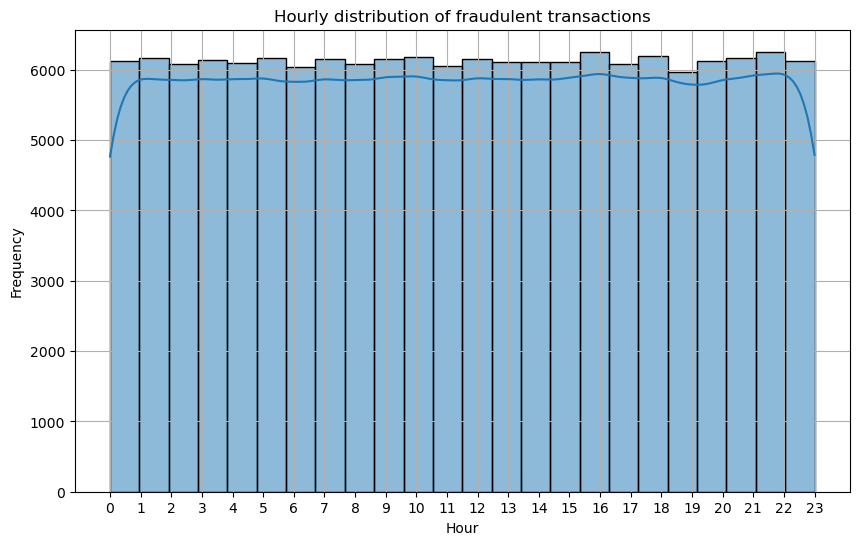

In [59]:
# Building a graph
plt.figure(figsize=(10, 6))
sns.histplot(data, x='hour', bins=24, edgecolor='black', kde=True)
plt.title('Hourly distribution of fraudulent transactions')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

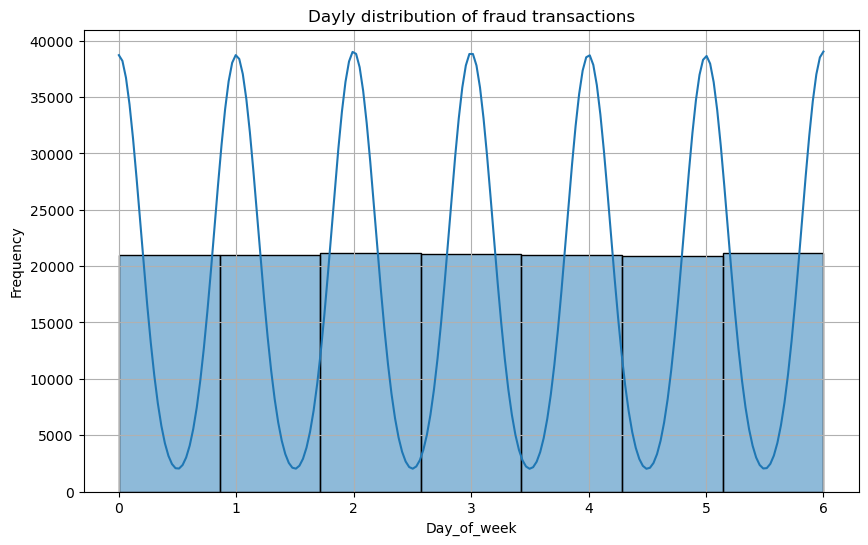

In [60]:
# Building a graph
plt.figure(figsize=(10, 6))
sns.histplot(data, x='day_of_week', bins=7, edgecolor='black', kde=True)
plt.title('Dayly distribution of fraud transactions')
plt.xlabel('Day_of_week')
plt.ylabel('Frequency')
plt.xticks(range(0, 7))
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Distribution of fraud transactions by months in 2020')

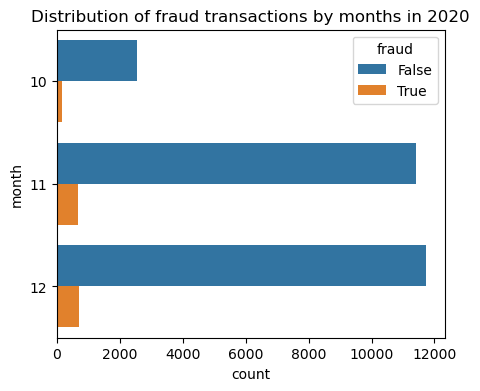

In [62]:
plt.figure(figsize=(5,4), facecolor='white')
sns.countplot(y='month', hue='fraud', data=data[data['year']==2020])
plt.title('Distribution of fraud transactions by months in 2020')

Text(0.5, 1.0, 'Distribution of fraud transactions by months in 2021')

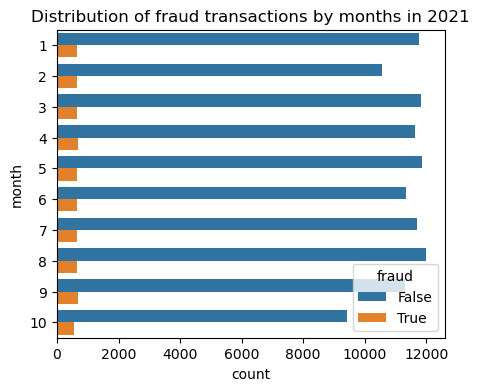

In [63]:
plt.figure(figsize=(5,4), facecolor='white')
sns.countplot(y='month', hue='fraud', data=data[data['year']==2021])
plt.title('Distribution of fraud transactions by months in 2021')

__Based on the presented graphs, no dependencies on the time of the operation are detected. However, this is not visible to the eye, but perhaps it will be useful to us when building a model.__